#Technical Analysis and pattern recognition in stocks

###by Christopher Wang

In this  notebook I will describe how to recognize basic technical patterns in stock charts using moving averages, as well as implementation of moving averages and other statistical analysis to find profitable stocks, and locate optimal buying and selling points.

DISCLAIMER UPDATE: This notebook was used for trial/research in attempt to practice how to utilize linear regression, moving averages, and to put them into code. Ultimately, it was unsuccessful in terms of profit, but was a good learning experience.

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn
from datetime import date

---

##Cup-With-Handle

A cup and handle is a price pattern on a security. It is the most common chart pattern typically lasting from 7 to 65 weeks, though most last for three to six months. The correction from absolute peak to absolute minimum should be between 15% and 33%. 

####Key Characteristics
- Handle should be above stock's 10-week moving average price line
- Proper handle should be contained iwthin 8% to 12% of its peak 
- Day's volume should be at least 40% to 50% above normal


###Examples of historic cups with handles
Intel Corp. from the Jaunuary 2016 to November 2016

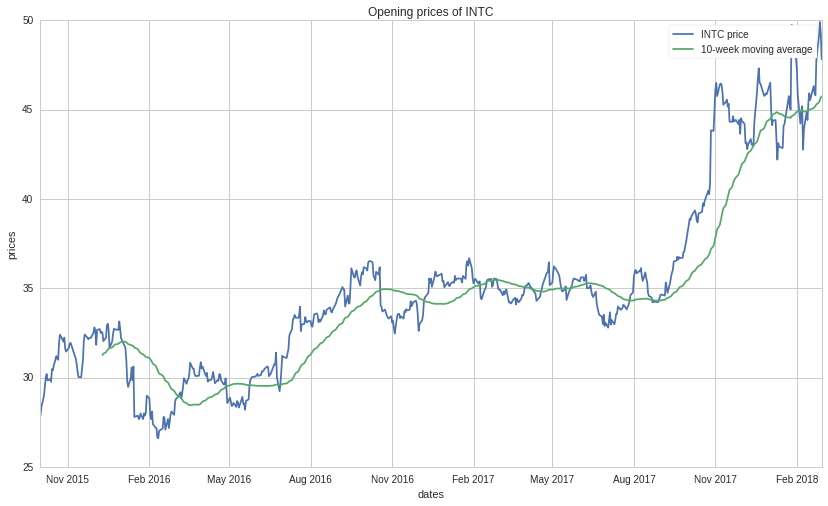

In [86]:
start = '2015-10-01'
end = '2018-03-01'
data_INTC = get_pricing(['INTC'], fields='price', start_date=start, end_date=end)
data_INTC.dropna()

data_INTC.columns = [c.symbol for c in data_INTC.columns]

moving_avg = data_INTC.rolling(window=50, center=False).mean();
moving_avg.name = "10-week moving average"


plt.plot(data_INTC['INTC'])
plt.plot(moving_avg)

plt.xlabel('dates');
plt.ylabel('prices');

plt.title('Opening prices of INTC');
plt.legend(['INTC price', '10-week moving average']);


Mastercard in 2016

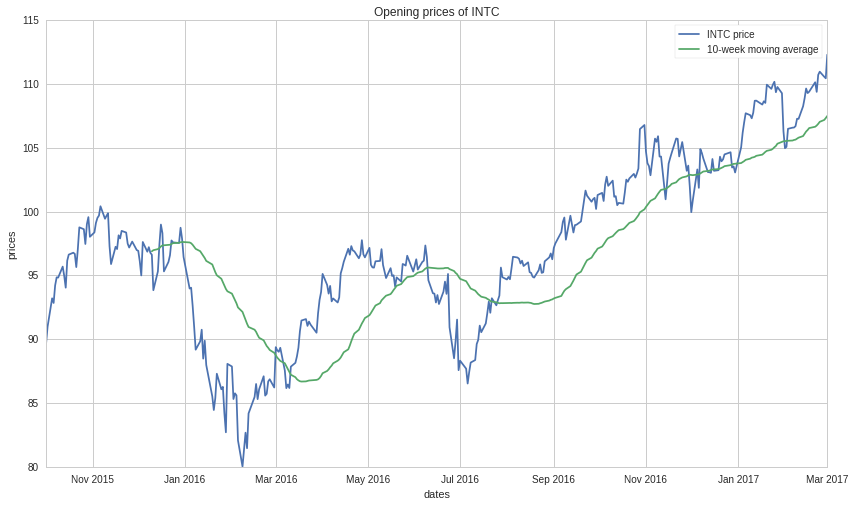

In [87]:
start = '2015-10-01'
end = '2017-03-01'
data_MA = get_pricing(['MA'], fields='price', start_date=start, end_date=end)
data_MA.dropna();

data_MA.columns = [c.symbol for c in data_MA.columns]

moving_avg = data_MA.rolling(window=50, center=False).mean();
moving_avg.name = "10-week moving average"


plt.plot(data_MA['MA'])
plt.plot(moving_avg)

plt.xlabel('dates');
plt.ylabel('prices');

plt.title('Opening prices of INTC');
plt.legend(['INTC price', '10-week moving average']);


##Double-Bottom

A double bottom is another price pattern on a security. This pattern looks like a "W", and does not occur as often as cup with handle. A double bottom does not always have handles

###Examples of double bottom

JBL fro June 2004 to June 2005

<class 'pandas.core.frame.DataFrame'>


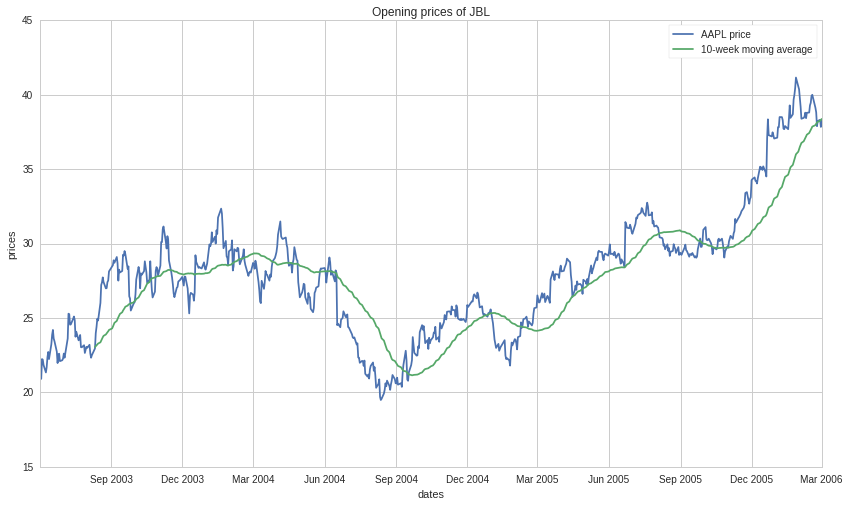

In [107]:
start = '2003-06-01'
end = '2006-03-01'
data_JBL = get_pricing(['JBL'], fields='price', start_date=start, end_date=end)
data_JBL = data_JBL.dropna()

data_JBL.columns = [c.symbol for c in data_JBL.columns]
data_JBL['date'] = data_JBL.index

moving_avg = data_JBL['JBL'].rolling(window=50, center=False).mean();
moving_avg.name = "10-week moving average"
frame = {'JBL': moving_avg}
moving_avg = pd.DataFrame(frame)

plt.plot(data_JBL['JBL'])
plt.plot(moving_avg['JBL'])

plt.xlabel('dates');
plt.ylabel('prices');

plt.title('Opening prices of JBL');
plt.legend(['AAPL price', '10-week moving average']);


---

#How to Locate Price Chart Patterns

Now that we have a general idea of what two of these patterns are, let's try to determine an algorithm to compute the optimal buying points.

When looking at the price charts, it is easy to distinguish when the optimal buying point is; the cup with handles and double bottom can both be easily identified.

To do this with code, we will take advantage of rolling averages. 

###Using rolling averages: recovery back to previous high

A commonality between these chart patterns is that the rolling averages of both stocks return to their previous high. This helps account for the "handle" part of the cup with handle pattern, as averages are less volatile and resist change.

By using a 10-week moving average, if there is a horizontal linear line between the highest recorded maximum on the rolling averages graph and the current price, then there is an optimum buy point

For example, in the horizontal line can be formed between March 2004 and June 2005 in the chart above of JBL.

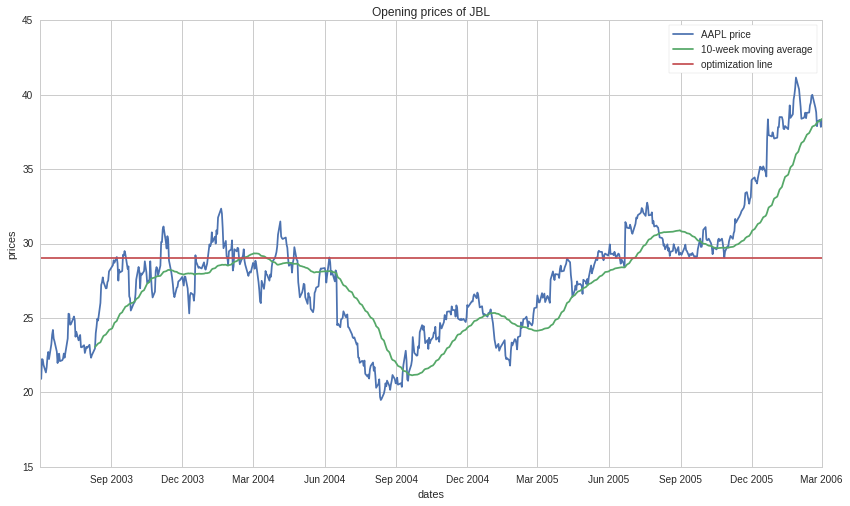

In [108]:
num_rows = data_JBL.index.size
y_price = [29] * num_rows
y_series = pd.Series(y_price, name="Price of line")
y_series.index = data_JBL.index

plt.plot(data_JBL['JBL'])
plt.plot(moving_avg)
plt.plot(y_series)

plt.xlabel('dates');
plt.ylabel('prices');

plt.title('Opening prices of JBL');
plt.legend(['AAPL price', '10-week moving average', 'optimization line']);


Looking at this graph, the most optimal buy point would be the **intersection between the red and green lines**

Now, let's do this analytically with code. 
First, find the local maximums and minimums of the rolling averages dataframe. Below, we have plotted red points at local minimas and maximas.

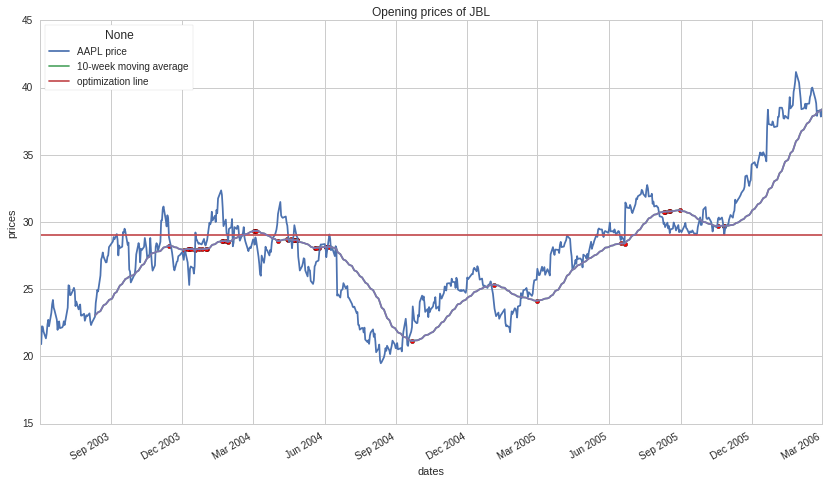

In [109]:
plt.plot(data_JBL['JBL'])
plt.plot(moving_avg)
plt.plot(y_series)

plt.xlabel('dates');
plt.ylabel('prices');

plt.title('Opening prices of JBL');
plt.legend(['AAPL price', '10-week moving average', 'optimization line'])


# Find local peaks
moving_avg['min'] = moving_avg.JBL[(moving_avg.JBL.shift(1) > moving_avg.JBL) & (moving_avg.JBL.shift(-1) > moving_avg.JBL)]
moving_avg['max'] = moving_avg.JBL[(moving_avg.JBL.shift(1) < moving_avg.JBL) & (moving_avg.JBL.shift(-1) < moving_avg.JBL)]

# Plot results
plt.scatter(moving_avg.index, moving_avg['min'], c='r')
plt.scatter(moving_avg.index, moving_avg['max'], c='r')
moving_avg.JBL.plot();

To this algorithmically we must:
1. Find a local maxima
2. Locate if there is a minima within the 4 to 40 weeks range that is 15% to 45% (Note: the actual number described by O'Neil are not precisley these percentages)
3. If (2) is False, then this pattern does not form a cup with handle; End here. Otherwise, continue iterate through the moving average price data until the price is equivalent to the maxima from (1)

In [115]:
df_min = moving_avg['min'].dropna()
df_max = moving_avg['max'].dropna()


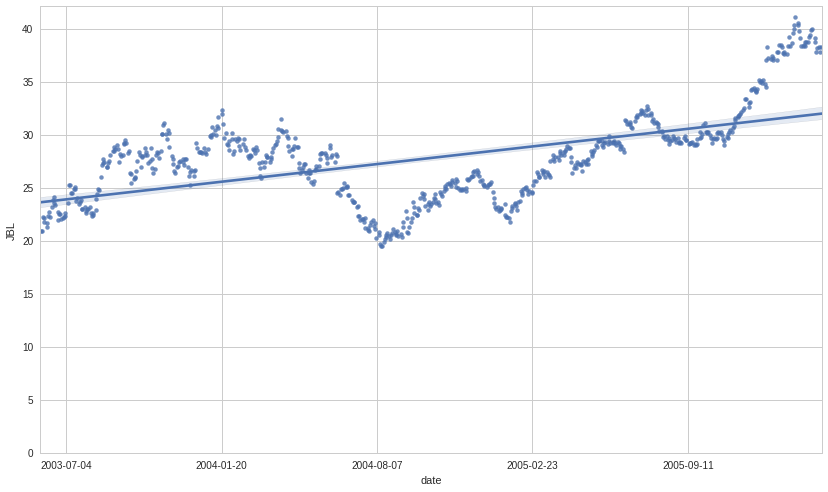

In [71]:
#print data_JBL.index.to_series()
data_JBL['date_ordinal'] = pd.to_datetime(data_JBL['date']).apply(lambda date: date.toordinal())

ax = seaborn.regplot(
    data=data_JBL,
    x='date_ordinal',
    y='JBL',
)

# Tighten up the axes for prettiness
ax.set_xlim(data_JBL['date_ordinal'].min() - 1, data_JBL['date_ordinal'].max() + 1)
ax.set_ylim(0, data_JBL['JBL'].max() + 1)

ax.set_xlabel('date')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels);



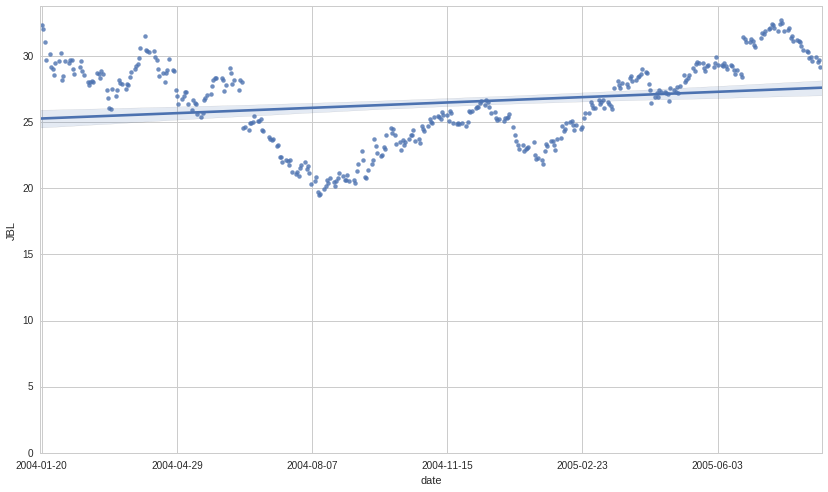

In [82]:
data_JBL['date_ordinal'] = pd.to_datetime(data_JBL['date']).apply(lambda date: date.toordinal())

range = (0, 40)
factor = 400
start = 160

while start < 170:
    df = data_JBL.iloc[start: start + factor]
    start = start + factor
    ax = seaborn.regplot(
        data=df,
        x='date_ordinal',
        y='JBL',
    )
    # Tighten up the axes for prettiness
    ax.set_xlim(df['date_ordinal'].min() - 1, df['date_ordinal'].max() + 1)
    ax.set_ylim(0, df['JBL'].max() + 1)

    ax.set_xlabel('date')
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels);

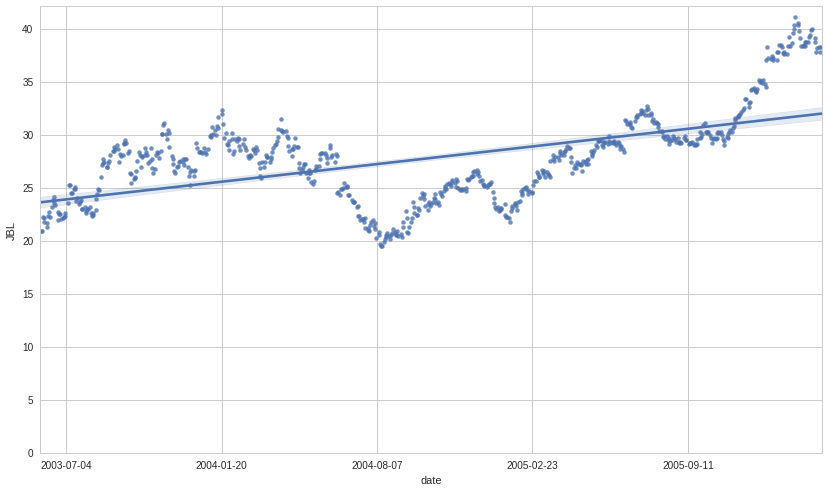

In [75]:
data_JBL['date_ordinal'] = pd.to_datetime(data_JBL['date']).apply(lambda date: date.toordinal())

range = (0, 40)
factor = data_JBL.index.size // 10
start = 0

while start < 1:
    df = data_JBL.iloc[start: start + factor]
    start = start + factor
    ax = seaborn.regplot(
        data=data_JBL,
        x='date_ordinal',
        y='JBL',
    )
    # Tighten up the axes for prettiness
    ax.set_xlim(data_JBL['date_ordinal'].min() - 1, data_JBL['date_ordinal'].max() + 1)
    ax.set_ylim(0, data_JBL['JBL'].max() + 1)

    ax.set_xlabel('date')
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels);

In [ ]:
"""
@param data is the dataframe containing data of stock
@returns null if there is no optimal buy point
"""
def find_buy_point(data)